Auteur: Michaël Leroy

 Graph depuis gdf Nodes et edges
        - calcul de stats
        - classif des communes 

        .....

In [28]:
class CFG:
    data_path = './osm_datas/'
    data_path_mappers = './datas'
    paths_path = './tourism_paths'
    area_name = 'france'

    start_cities = [
        "Paris",
        "Marseille",
        "Lyon",
        "Toulouse",
        "Nice",
        "Nantes",
        "Strasbourg",
        "Montpellier",
        "Bordeaux",
        "Lille",
        "Rennes",
        "Reims",
        "Le Havre",
        # "Cergy-Pontoise",
        "Saint-Étienne",
        "Toulon",
        "Angers",
        "Grenoble",
        "Dijon",
        "Nîmes",
        "Aix-en-Provence",
        # "Saint-Quentin-en-Yvelines",
        "Brest",
        "Le Mans",
        "Amiens",
        "Tours",
        "Limoges",
        "Clermont-Ferrand",
        # "Villeurbanne",
        "Besançon",
        "Orléans",
        "Metz",
        "Rouen",
        "Mulhouse",
        "Perpignan",
        "Caen",
        # "Boulogne-Billancourt",
        "Nancy",
        # "Argenteuil",
        # "Saint-Denis",
        # "Roubaix",
        # "Tourcoing",
        "Avignon",
        "Poitiers",
        # "Fort-de-France",
        # "Créteil",
        "Dunkerque",
        # "Vitry-sur-Seine",
        "Pau",
        "La Rochelle"
    ]
    ## POIs
    # 80 to max : 456   done
    # 20 to 80  : 2057  done
    # 10 to 20  : 2941  done
    # 5 to 10   : 4970  done 
    # 3 to 5    : 4802  done
    # 2 to 3    : 3985  done
    # 1 to 2    : 5291  done

    Min_Pois = 1
    Max_Pois = 2
    

import os
os.environ['USE_PYGEOS'] = '0'

import joblib
joblib.dump(
    CFG, 
    os.path.join(
        CFG.paths_path,
        'CFG_for_tourism_paths.pkl'
    ) 
)   


# %load_ext autoreload
# %autoreload


# %aimport OSM_helper_functions
# %aimport OCM_helper_functions

import numpy as np
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
# from OSM_helper_functions import *
# from OCM_helper_functions import *


ox.settings.log_console=True
ox.settings.use_cache=True
''' To retrieve http data from OSMnx and cache them locally
    before building graph. Raise and exception if requests
    are all done. intercept then set to False and retry.'''
# ox.settings.cache_only_mode=True 



' To retrieve http data from OSMnx and cache them locally\n    before building graph. Raise and exception if requests\n    are all done. intercept then set to False and retry.'

In [2]:
Nodes = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gnodes_communes.pkl'))

Edges = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gedges_communes_C22.pkl'))

In [3]:
Nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34466 entries, 2531584 to 2741108
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   y         34466 non-null  float64 
 1   x         34466 non-null  float64 
 2   codgeo    34466 non-null  object  
 3   area      34466 non-null  object  
 4   sleeping  15412 non-null  float64 
 5   visit     17923 non-null  float64 
 6   fooding   6616 non-null   float64 
 7   working   6950 non-null   float64 
 8   vehicule  4166 non-null   float64 
 9   geometry  34466 non-null  geometry
dtypes: float64(7), geometry(1), object(2)
memory usage: 3.9+ MB


In [4]:
Edges = Edges.drop(['src_trgt'], axis=1)
Edges = Edges.reset_index()

Edges['u'] = Edges['u'].astype(str)
Edges['v'] = Edges['v'].astype(str)
Edges['key'] = Edges['key'].astype(str)

Edges = Edges.set_index(['u','v','key'])
PATHS = Edges.pop('path')
Edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 205450 entries, ('2531584', '2176035', '0') to ('2741108', '2740963', '0')
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     205450 non-null  geometry
 1   length       205450 non-null  float64 
 2   travel_time  205450 non-null  float64 
 3   path_line    205450 non-null  object  
dtypes: float64(2), geometry(1), object(1)
memory usage: 10.6+ MB


In [5]:
nodes2codgeo = dict(zip(Nodes.index, Nodes['codgeo']))

In [6]:
display(Nodes.head(2),Edges.head(2))

,y,x,codgeo,area,sleeping,visit,fooding,working,vehicule,geometry
osmid,,,,,,,,,,
2531584,43.461438,-0.819766,64312,POLYGON ((-0.832953105776137 43.44755970632465...,2.0,NaN,NaN,NaN,NaN,POINT (-0.81977 43.46144)
279376,47.730421,0.777490,41255,POLYGON ((0.7426134063245691 47.72901158483156...,NaN,1.0,NaN,NaN,NaN,POINT (0.77749 47.73042)


geometry  \
u       v       key                                                      
2531584 2176035 0    LINESTRING (-0.81977 43.46144, -0.84879 43.43624)   
        167704  0    LINESTRING (-0.81977 43.46144, -0.77384 43.48750)   

                       length  travel_time  \
u       v       key                          
2531584 2176035 0    6669.304        466.3   
        167704  0    6019.824        403.2   

                                                             path_line  
u       v       key                                                     
2531584 2176035 0    LINESTRING (-0.820294 43.4613392, -0.819854 43...  
        167704  0    LINESTRING (-0.820294 43.4613392, -0.819854 43...

In [7]:
G_communes = ox.graph_from_gdfs(Nodes, Edges)

In [8]:
# Mappers to link osmids to commune names


# Dict to map osmid  -> communes names
Osmid2Name = joblib.load(
    os.path.join(CFG.data_path_mappers,f'[{CFG.area_name}]mapper_osmid_to_libgeo.pkl')
)

# Dict to map communes names  -> osmid 
Name2Osmid = joblib.load(
    os.path.join(CFG.data_path_mappers,f'[{CFG.area_name}]mapper_libgeo_to_osmid.pkl')
)

- 1- prendre les zones à forte population

    * pour cette poc pas de ranking mais une liste predéfine de villes

In [9]:
# start_cities = ['Reims','Lyon','lille','brest','bordeaux','perpignan']



# start_cities to start_nodes
start_nodes = [ Name2Osmid[str.upper(name)] for name in CFG.start_cities]
# start_nodes, 
len(start_nodes)

39

2- Communes ayant un intérêt 

    * création d'une liste de communes ayant des poi
    * il faut donner un poids aux communes en fonction de leur 'interêt', pour l'instant juste le nombre de pois rescencés

,y,x,codgeo,area,sleeping,visit,fooding,working,vehicule,geometry,poi_counts
osmid,,,,,,,,,,,
2531584,43.461438,-0.819766,64312,POLYGON ((-0.832953105776137 43.44755970632465...,2.0,NaN,NaN,NaN,NaN,POINT (-0.81977 43.46144),2.0
279376,47.730421,0.777490,41255,POLYGON ((0.7426134063245691 47.72901158483156...,NaN,1.0,NaN,NaN,NaN,POINT (0.77749 47.73042),1.0


<AxesSubplot: ylabel='Density'>

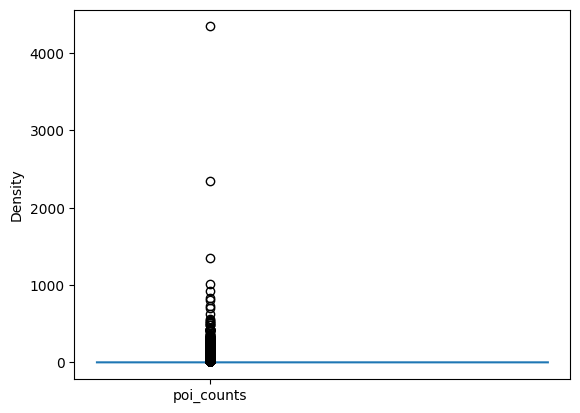

In [10]:
Nodes['poi_counts'] = Nodes[
    ['sleeping','visit','working','fooding','vehicule']
    ].fillna(0, axis=1).sum(axis=1)
display(Nodes.head(2))

Nodes.poi_counts.plot(kind='kde')

Nodes.poi_counts.replace(0, np.nan).plot(kind='box')

In [11]:
head_pois = Nodes.query("poi_counts >= 1000 ")
[ Osmid2Name[id] for id in head_pois.index]

['MARSEILLE', 'LYON', 'VICHY', 'PARIS']

In [12]:
# tail_pois = Nodes.query("poi_counts >100 and poi_counts <= 200 ").sample(20)
# display(tail_pois)
# [ Osmid2Name[id] for id in tail_pois.index]

In [29]:
Min = CFG.Min_Pois
Max = CFG.Max_Pois

goal_nodes = Nodes.query(
                "poi_counts >= @Min and poi_counts < @Max "
    ).sort_values(by='poi_counts',
                  ascending=True
    ).index.tolist()

goal_nodes = [ node for node in goal_nodes if ~(node in start_nodes)]
# goal_nodes.remove('59355')

goal_cities = [ Osmid2Name[node] if node in Osmid2Name.keys() else 'Unknown' for node in goal_nodes]
# display(goal_cities, len(goal_cities))
len(goal_cities)

5291

- 3-chercher des 'paths' vers les zones touristiques



In [18]:
# from tqdm.notebook import tqdm
# tqdm.pandas()


def get_shortest_path( src: str, trgt: str) -> tuple:
    duration, path = nx.single_source_dijkstra(
                G_communes, 
                source=src, 
                target=trgt, 
                weight='travel_time', 
                )
    distance = nx.path_weight(G_communes, path, weight='length')
    return duration, path, distance

# get_shortest_path( start_nodes[0], goal_nodes[0])

-------------------------------------

In [30]:
# Store scores, start_cities and goal_cities to continue scoring


def get_path_from_start( start: str, goals: list[str]) -> tuple[pd.DataFrame,dict]:
    # _errors = dict()
    _path_df = pd.DataFrame(columns=[['start','goal','path','distance','duration']],
                            # index = [i for i in range(len(goals))]
                              )

    for idx, goal in enumerate(tqdm(goals, desc= Osmid2Name[start])):
        # print(f'{idx=}  {goal=}')
        _path_df.loc[idx, 'goal'] = goal    

        try:
            duration, path, distance = get_shortest_path( start, goal)
            # print(f'{dist=}  {path=}')
            _path_df.loc[idx, 'duration'] = duration
            _path_df.loc[idx, 'distance'] = distance
            _path_df.loc[idx, 'path'] = [ [p] for p in path[1:-1]]
        except: 
            # _path_df.loc[idx, 'dist'] = 0
            # _path_df.loc[idx, 'duration'] = 0
            _path_df.loc[idx, 'path'] = ['error'] 
        # break
    _path_df['start'] = start
    _path_df['duration'] = _path_df['duration'].astype(float)
    _path_df['distance'] = _path_df['distance'].astype(float)

    _path_df = _path_df[_path_df.start.values !=  _path_df.goal.values]
    
    return _path_df



for start in tqdm(start_nodes, desc='Start Cities', leave=True):
    file_name = os.path.join(
                    CFG.paths_path, 
                    f'from_[{Osmid2Name[start]}]_paths.pkl'
    )
    if os.path.exists(file_name):   
        done_paths = joblib.load(
            file_name
        )    
        to_do_goals = list(set(goal_nodes) - set([ node[0] for node in done_paths.goal.values]))
        # print(f'{to_do_goals}') 
        if to_do_goals:
            new_paths = get_path_from_start(start, to_do_goals)
            joblib.dump(
                pd.concat(
                    [done_paths, new_paths], 
                    axis= 0 , 
                    ignore_index=True
                ),
            file_name
            )
            del new_paths
        del to_do_goals, done_paths, file_name    
        
    else:
        joblib.dump(
            get_path_from_start(start, goal_nodes),
            file_name
        )
        del file_name
    # break



Start Cities:   0%|          | 0/39 [00:00<?, ?it/s]

PARIS:   0%|          | 0/5291 [00:00<?, ?it/s]

MARSEILLE:   0%|          | 0/5291 [00:00<?, ?it/s]

LYON:   0%|          | 0/5291 [00:00<?, ?it/s]

TOULOUSE:   0%|          | 0/5291 [00:00<?, ?it/s]

NICE:   0%|          | 0/5291 [00:00<?, ?it/s]

NANTES:   0%|          | 0/5291 [00:00<?, ?it/s]

STRASBOURG:   0%|          | 0/5291 [00:00<?, ?it/s]

MONTPELLIER:   0%|          | 0/5291 [00:00<?, ?it/s]

BORDEAUX:   0%|          | 0/5291 [00:00<?, ?it/s]

LILLE:   0%|          | 0/5291 [00:00<?, ?it/s]

RENNES:   0%|          | 0/5291 [00:00<?, ?it/s]

REIMS:   0%|          | 0/5291 [00:00<?, ?it/s]

LE HAVRE:   0%|          | 0/5291 [00:00<?, ?it/s]

SAINT-ÉTIENNE:   0%|          | 0/5291 [00:00<?, ?it/s]

TOULON:   0%|          | 0/5291 [00:00<?, ?it/s]

ANGERS:   0%|          | 0/5291 [00:00<?, ?it/s]

GRENOBLE:   0%|          | 0/5291 [00:00<?, ?it/s]

DIJON:   0%|          | 0/5291 [00:00<?, ?it/s]

NÎMES:   0%|          | 0/5291 [00:00<?, ?it/s]

AIX-EN-PROVENCE:   0%|          | 0/5291 [00:00<?, ?it/s]

BREST:   0%|          | 0/5291 [00:00<?, ?it/s]

LE MANS:   0%|          | 0/5291 [00:00<?, ?it/s]

AMIENS:   0%|          | 0/5291 [00:00<?, ?it/s]

TOURS:   0%|          | 0/5291 [00:00<?, ?it/s]

LIMOGES:   0%|          | 0/5291 [00:00<?, ?it/s]

CLERMONT-FERRAND:   0%|          | 0/5291 [00:00<?, ?it/s]

BESANÇON:   0%|          | 0/5291 [00:00<?, ?it/s]

ORLÉANS:   0%|          | 0/5291 [00:00<?, ?it/s]

METZ:   0%|          | 0/5291 [00:00<?, ?it/s]

ROUEN:   0%|          | 0/5291 [00:00<?, ?it/s]

MULHOUSE:   0%|          | 0/5291 [00:00<?, ?it/s]

PERPIGNAN:   0%|          | 0/5291 [00:00<?, ?it/s]

CAEN:   0%|          | 0/5291 [00:00<?, ?it/s]

NANCY:   0%|          | 0/5291 [00:00<?, ?it/s]

AVIGNON:   0%|          | 0/5291 [00:00<?, ?it/s]

POITIERS:   0%|          | 0/5291 [00:00<?, ?it/s]

DUNKERQUE:   0%|          | 0/5291 [00:00<?, ?it/s]

PAU:   0%|          | 0/5291 [00:00<?, ?it/s]

LA ROCHELLE:   0%|          | 0/5291 [00:00<?, ?it/s]

---------------------------------------